<a href="https://colab.research.google.com/github/Arpitkamal/Deep-Learning---Deep-Convolutional-Neural-Networks/blob/master/LargeCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline

*   Loading datasets - Transforming images
*   VGG-16 with modification to network head
*   using pre-trained models
*   Storing intermediate models
*   Resnet
*   Inception v3
*   Exercise





In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim #for backpropagation

In [2]:
device = torch.device("cuda:0")
print(device)

cuda:0


# Dataset, transforms and visualisation

In [3]:
transform_train = transforms.Compose([
         transforms.RandomResizedCrop(224),  #resizing and croping
         transforms.ToTensor(),              #converted to tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   #Normalization                         
])

transform_test = transforms.Compose([
         transforms.RandomResizedCrop(224),  #resizing and croping
         transforms.ToTensor(),              #converted to tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   #Normalization                         
])



In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform= transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10

In [6]:
batch_size = 4

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(trainloader) #instantiating iterator for trainloader 
images, labels = dataiter.next() # return one batch

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
9


In [9]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5                #converting the image to numpy and unnormalizing it 
  plt.figure(figsize=(batch_size, 1))          #(width, height)
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [10]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

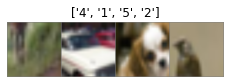

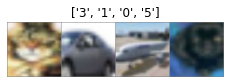

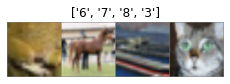

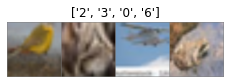

In [11]:
for i in range(4):
  show_batch_images(trainloader)

# Creating VGG-16

In [12]:
from torchvision import models

In [13]:
vgg = models.vgg16_bn()

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [16]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


We have to change output features to 10

In [17]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]  #excluding last linear layer
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) # num_classes is defined to be 10 earlier
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [18]:
vgg.classifier = nn.Sequential(*mod_classifier) #defining modified classifier
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Training the VGG 

In [19]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [20]:
def evaluation(Dataloader, model):
  total, correct = 0,0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total  

In [21]:
vgg = vgg.to(device)            # taking model to device 
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [22]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)              #forward pass
    loss = loss_fn(outputs, labels)   #compute loss
    loss.backward()                   #backward pass
    opt.step()                       #updating the weights
 
    del inputs, labels, outputs
    torch.cuda.empty_cache()          #to make sure memory usage in GPU is small

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
    
  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % epoch, max_epochs, evaluation(testloader, vgg),
        evaluation(trainloader, vgg))
  
plt.plot(loss_epoch_arr)
plt.show()  

Iteration: 0/3125, Loss: 2.46


KeyboardInterrupt: ignored

# Freeze layers of Convolutional Operations(Transfer Learning)

In [23]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [24]:
vgg = models.vgg16_bn(pretrained=True)  #predtrained model downloaded

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [25]:
for param in vgg.parameters():      #if am doing backpropagation then don't update weight and bias(frozen paramerters)
  param.requires_grad = False      

Another way of changing last layer to 10 output features

In [26]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [27]:
vgg = vgg.to(device)            # taking model to device 
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)              #forward pass
    loss = loss_fn(outputs, labels)   #compute loss
    loss.backward()                   #backward pass
    opt.step()                       #updating the weights
 
    del inputs, labels, outputs
    torch.cuda.empty_cache()          #to make sure memory usage in GPU is small

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
    
  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % epoch, max_epochs, evaluation(testloader, vgg),
        evaluation(trainloader, vgg))
  
plt.plot(loss_epoch_arr)
plt.show()  

# With model copies

In [28]:
import copy

In [29]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)              #forward pass
    loss = loss_fn(outputs, labels)   #compute loss
    loss.backward()                   #backward pass
    opt.step()                       #updating the weights

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())   # making the deep copy of best model
      print('Min loss %0.2f'% min_loss)

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f'%(i, n_iters, loss.item()))  
 
    del inputs, labels, outputs
    torch.cuda.empty_cache()          #to make sure memory usage in GPU is small

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
    
  loss_epoch_arr.append(loss.item())

  

Min loss 2.40
Iteration: 0/3125, Loss: 2.40
Iteration: 0/3125, Loss: 2.40
Min loss 2.24
Min loss 2.21
Min loss 2.02
Min loss 1.96
Min loss 1.89
Min loss 1.38
Min loss 1.30
Min loss 0.96
Iteration: 100/3125, Loss: 2.41
Iteration: 100/3125, Loss: 2.41
Iteration: 200/3125, Loss: 1.86
Iteration: 200/3125, Loss: 1.86
Min loss 0.88
Iteration: 300/3125, Loss: 1.49
Iteration: 300/3125, Loss: 1.49
Min loss 0.86
Iteration: 400/3125, Loss: 1.62
Iteration: 400/3125, Loss: 1.62
Iteration: 500/3125, Loss: 1.44
Iteration: 500/3125, Loss: 1.44
Min loss 0.86
Min loss 0.80
Iteration: 600/3125, Loss: 2.38
Iteration: 600/3125, Loss: 2.38
Min loss 0.77
Iteration: 700/3125, Loss: 2.01
Iteration: 700/3125, Loss: 2.01
Iteration: 800/3125, Loss: 1.25
Iteration: 800/3125, Loss: 1.25
Iteration: 900/3125, Loss: 1.84
Iteration: 900/3125, Loss: 1.84
Iteration: 1000/3125, Loss: 1.47
Iteration: 1000/3125, Loss: 1.47
Iteration: 1100/3125, Loss: 1.92
Iteration: 1100/3125, Loss: 1.92
Min loss 0.66
Iteration: 1200/3125, 

KeyboardInterrupt: ignored

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

# ResNet Model

In [30]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [31]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
for param in resnet.parameters():   #we don't want to train all the parameter again. we will use pretrained weights.
  param.requires_grad = False

In [33]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [34]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [36]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

In [37]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)              #forward pass
    loss = loss_fn(outputs, labels)   #compute loss
    loss.backward()                   #backward pass
    opt.step()                       #updating the weights

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())   # making the deep copy of best model
      print('Min loss %0.2f'% min_loss)

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f'%(i, n_iters, loss.item()))  
 
    del inputs, labels, outputs
    torch.cuda.empty_cache()          #to make sure memory usage in GPU is small
    
  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' %(epoch, max_epochs, 
                                                            evaluation(testloader, resnet), evaluation(trainloader, resnet)))
  
plt.plot(loss_epoch_arr)
plt.show()  

  

Min loss 2.54
Iteration: 0/3125, Loss: 2.54
Min loss 2.20
Min loss 2.10
Min loss 1.80
Min loss 1.69
Min loss 1.60
Min loss 1.46
Min loss 1.29
Min loss 1.25
Min loss 1.03
Min loss 0.80
Iteration: 100/3125, Loss: 2.87
Iteration: 200/3125, Loss: 2.21
Iteration: 300/3125, Loss: 1.68
Min loss 0.56
Iteration: 400/3125, Loss: 1.90
Iteration: 500/3125, Loss: 2.52
Iteration: 600/3125, Loss: 1.49
Iteration: 700/3125, Loss: 2.04
Iteration: 800/3125, Loss: 1.14
Iteration: 900/3125, Loss: 2.48
Iteration: 1000/3125, Loss: 2.21
Iteration: 1100/3125, Loss: 1.92
Iteration: 1200/3125, Loss: 2.25
Iteration: 1300/3125, Loss: 0.99
Min loss 0.48
Iteration: 1400/3125, Loss: 2.14
Iteration: 1500/3125, Loss: 1.44
Iteration: 1600/3125, Loss: 1.24
Iteration: 1700/3125, Loss: 2.58
Iteration: 1800/3125, Loss: 2.24
Iteration: 1900/3125, Loss: 1.75
Iteration: 2000/3125, Loss: 1.86
Iteration: 2100/3125, Loss: 2.07
Iteration: 2200/3125, Loss: 2.29
Iteration: 2300/3125, Loss: 2.36
Iteration: 2400/3125, Loss: 2.35
Itera

NameError: ignored